In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
import torch
import numpy as np

warnings.filterwarnings('ignore')
torch.set_num_threads(1)

# Add parent directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fsrs_optimizer import rmse_matrix, remove_outliers, remove_non_continuous_rows
from utils import cum_concat

# Configuration
SECS_IVL = False
TWO_BUTTONS = False
max_seq_len = 64
rust = False

if rust:
    os.environ["FSRS_NO_OUTLIER"] = "1"
    from fsrs_rs_python import FSRS, FSRSItem, FSRSReview
    backend = FSRS(parameters=[])
    

# Define create_time_series function here to avoid argparse conflicts
def create_time_series(df):
    """Create time series features from review logs"""
    df["review_th"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "review_th"], inplace=True)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.drop(df[df["i"] > max_seq_len * 2].index, inplace=True)
    
    if TWO_BUTTONS:
        df.loc[:, "rating"] = df.loc[:, "rating"].map({1: 1, 2: 3, 3: 3, 4: 3})
    
    card_id_to_first_rating = df.groupby("card_id")["rating"].first().to_dict()
    
    if "delta_t" not in df.columns:
        if SECS_IVL and "elapsed_seconds" in df.columns:
            df["delta_t"] = df["elapsed_seconds"] / 86400
        elif "elapsed_days" in df.columns:
            df["delta_t"] = df["elapsed_days"]
    
    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, i)] for i in x])
    )
    r_history_list = df.groupby("card_id", group_keys=False)["rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    df["tensor"] = [
        torch.tensor((t_item[:-1], r_item[:-1])).transpose(0, 1)
        for t_sublist, r_sublist in zip(t_history_list, r_history_list)
        for t_item, r_item in zip(t_sublist, r_sublist)
    ]
    
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    
    df["last_rating"] = last_rating
    df["y"] = df["rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df.drop(df[df["elapsed_days"] == 0].index, inplace=True)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["card_id"].map(card_id_to_first_rating).astype(str)
    
    if not SECS_IVL:
        filtered_dataset = (
            df[df["i"] == 2]
            .groupby(by=["first_rating"], as_index=False, group_keys=False)[df.columns]
            .apply(remove_outliers)
        )
        if filtered_dataset.empty:
            return pd.DataFrame()
        df[df["i"] == 2] = filtered_dataset
        df.dropna(inplace=True)
        df = df.groupby("card_id", as_index=False, group_keys=False)[df.columns].apply(
            remove_non_continuous_rows
        )
    
    return df[df["elapsed_days"] > 0].sort_values(by=["review_th"])

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

def convert_to_items(df):  # -> list[FSRSItem]
    """Convert DataFrame to list of FSRSItem for Rust backend"""

    def accumulate(group):
        items = []
        for _, row in group.iterrows():
            t_history = [max(0, int(t)) for t in row["t_history"].split(",")] + [
                row["delta_t"]
            ]
            r_history = [int(t) for t in row["r_history"].split(",")] + [row["rating"]]
            items.append(
                (
                    row["review_th"],
                    FSRSItem(
                        reviews=[
                            FSRSReview(delta_t=int(x[0]), rating=int(x[1]))
                            for x in zip(t_history, r_history)
                        ]
                    ),
                )
            )
        return items

    result_list = sum(
        df.sort_values(by=["card_id", "review_th"])
        .groupby("card_id")
        .apply(accumulate)
        .tolist(),
        [],
    )
    result_list = list(map(lambda x: x[1], sorted(result_list, key=lambda x: x[0])))

    return result_list

In [3]:
DATA_PATH = Path("../../anki-revlogs-10k")

user_id = 1000

print(f"Data path: {DATA_PATH}")
print(f"Data path exists: {DATA_PATH.exists()}")

# Load revlogs following data_loader.py pattern
revlog_path = DATA_PATH / "revlogs" / f"{user_id=}"
print(f"Attempting to load from: {revlog_path}")

df_revlogs = pd.read_parquet(revlog_path)
print(f"Loaded {len(df_revlogs)} reviews")

# Filter ratings (keep only valid ratings 1-4)
df_revlogs = df_revlogs[df_revlogs["rating"].isin([1, 2, 3, 4])].copy()
print(f"After filtering: {len(df_revlogs)} reviews")

# Select necessary columns
required_cols = ["card_id", "rating", "elapsed_days"]
if SECS_IVL and "elapsed_seconds" in df_revlogs.columns:
    required_cols.append("elapsed_seconds")

df_revlogs = df_revlogs[required_cols]

# Create time series features
dataset = create_time_series(df_revlogs)
dataset.reset_index(drop=True, inplace=True)

print(f"\nDataset shape: {dataset.shape}")
print(f"Columns: {list(dataset.columns)}")
print(f"Number of cards: {dataset['card_id'].nunique()}")
print(f"Number of reviews: {len(dataset)}")

Data path: ../../anki-revlogs-10k
Data path exists: True
Attempting to load from: ../../anki-revlogs-10k/revlogs/user_id=1000
Loaded 26010 reviews
After filtering: 26010 reviews

Dataset shape: (19299, 12)
Columns: ['card_id', 'rating', 'elapsed_days', 'review_th', 'i', 'delta_t', 'r_history', 't_history', 'tensor', 'last_rating', 'y', 'first_rating']
Number of cards: 622
Number of reviews: 19299


Starting progressive training with step size 1000...


Training progress: 100%|██████████| 19/19 [00:59<00:00,  3.11s/it]

Training completed!


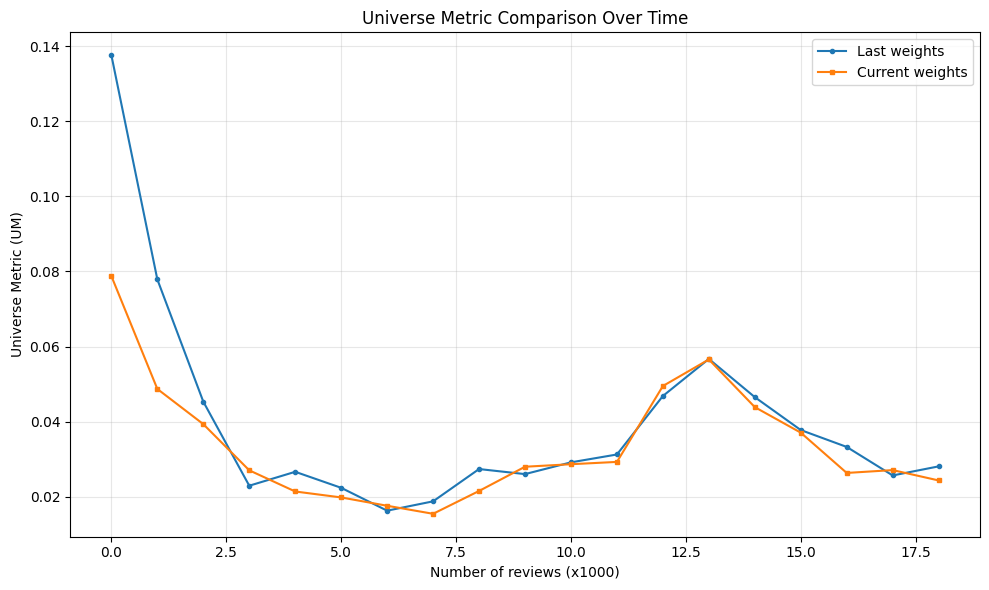

UM improvement rate: 73.68%


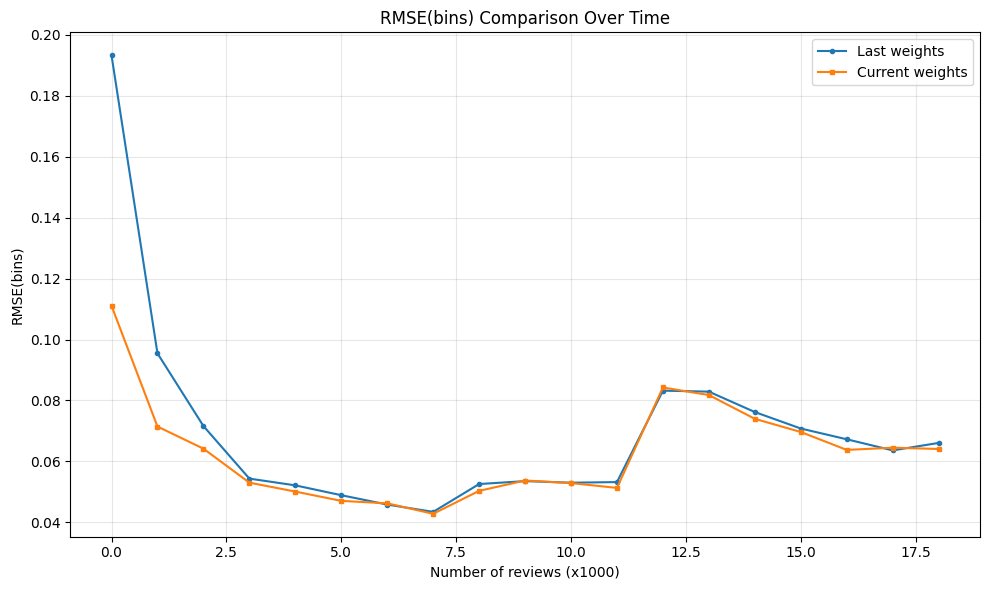

RMSE improvement rate: 78.95%


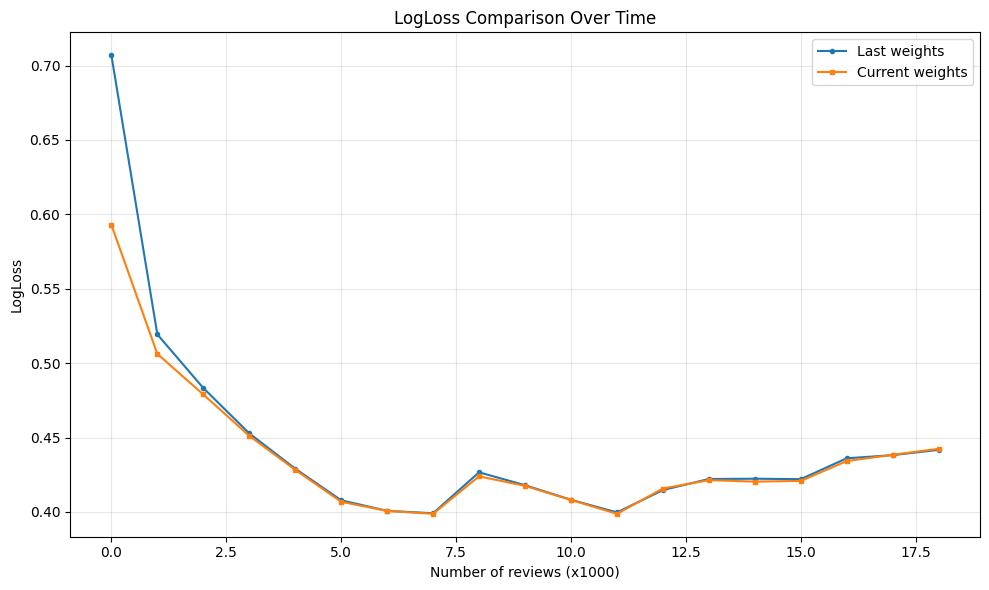

LogLoss improvement rate: 84.21%


In [4]:
from fsrs_optimizer import (
    Optimizer,
    Collection,
    Trainer,
    power_forgetting_curve,
    cross_comparison
)
import numpy as np
from sklearn.metrics import log_loss
from tqdm.auto import tqdm

# Initialize optimizer
optimizer = Optimizer()
optimizer.define_model()

def evaluate(weights, eval_set):
    """Evaluate model performance with given weights"""
    my_collection = Collection(weights)
    stabilities, difficulties = my_collection.batch_predict(eval_set)
    eval_set = eval_set.copy()
    eval_set["stability"] = [round(x, 2) for x in stabilities]
    eval_set["difficulty"] = [round(x, 2) for x in difficulties]
    eval_set["p"] = power_forgetting_curve(eval_set["delta_t"], eval_set["stability"])
    logloss = log_loss(eval_set["y"], eval_set["p"])
    rmse_bins = rmse_matrix(eval_set)
    return logloss, rmse_bins

def evaluate_improvement(old_weights, new_weights, eval_set):
    """Compare performance between old and new weights"""
    # Old weights prediction
    old_collection = Collection(old_weights)
    s_old, _ = old_collection.batch_predict(eval_set)
    old_p = power_forgetting_curve(eval_set["delta_t"], s_old)
    
    # New weights prediction
    new_collection = Collection(new_weights)
    s_new, _ = new_collection.batch_predict(eval_set)
    new_p = power_forgetting_curve(eval_set["delta_t"], s_new)
    
    # Cross comparison
    comparison_df = pd.DataFrame({
        "R (old)": old_p, 
        "R (new)": new_p, 
        "y": eval_set["y"]
    })
    (um_new, um_old), fig = cross_comparison(comparison_df, "old", "new")
    plt.close("all")
    return um_new, um_old
    


# Training configuration
lr = 4e-2
n_epoch = 5
batch_size = 512
verbose = False
step = 1000

# Initialize tracking variables
last_weights = optimizer.init_w.copy()
um_last, um_cur = [], []
rmse_last, rmse_cur = [], []
logloss_last, logloss_cur = [], []

# Progressive training
print(f"Starting progressive training with step size {step}...")
for max_index in tqdm(range(step, len(dataset), step), desc="Training progress"):
    train_set = dataset.loc[:max_index].copy()
    if rust:
        items = convert_to_items(train_set)
        weights = list(map(lambda x: round(x, 4), backend.benchmark(items)))
    else:
        # Python-based training
        optimizer.define_model()
        optimizer.init_w = last_weights.copy()
        
        # Initialize parameters with current training set
        _ = optimizer.initialize_parameters(dataset=train_set, verbose=verbose)
        
        # Fine-tune with trainer
        trainer = Trainer(
            train_set,
            None,
            optimizer.init_w,
            n_epoch=n_epoch,
            lr=lr,
            batch_size=batch_size,
        )
        weights = trainer.train(verbose=verbose)
    # Evaluate improvements
    um_new, um_old = evaluate_improvement(last_weights, weights, train_set)
    um_last.append(um_old)
    um_cur.append(um_new)
    
    # Evaluate metrics with last weights
    logloss, rmse = evaluate(last_weights, train_set)
    rmse_last.append(rmse)
    logloss_last.append(logloss)
    
    # Evaluate metrics with current weights
    logloss, rmse = evaluate(weights, train_set)
    rmse_cur.append(rmse)
    logloss_cur.append(logloss)
    
    # Update weights for next iteration
    last_weights = weights.copy() if not rust else weights

print("Training completed!")

# Plot Universe Metric (UM) comparison
plt.figure(figsize=(10, 6))
plt.plot(um_last, label="Last weights", marker='o', markersize=3)
plt.plot(um_cur, label="Current weights", marker='s', markersize=3)
plt.xlabel(f"Number of reviews (x{step})")
plt.ylabel("Universe Metric (UM)")
plt.title("Universe Metric Comparison Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
improvement_rate_um = sum((np.array(um_cur) < np.array(um_last))) / len(um_cur)
print(f"UM improvement rate: {improvement_rate_um:.2%}")

# Plot RMSE(bins) comparison
plt.figure(figsize=(10, 6))
plt.plot(rmse_last, label="Last weights", marker='o', markersize=3)
plt.plot(rmse_cur, label="Current weights", marker='s', markersize=3)
plt.xlabel(f"Number of reviews (x{step})")
plt.ylabel("RMSE(bins)")
plt.title("RMSE(bins) Comparison Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
improvement_rate_rmse = sum((np.array(rmse_cur) < np.array(rmse_last))) / len(rmse_cur)
print(f"RMSE improvement rate: {improvement_rate_rmse:.2%}")

# Plot LogLoss comparison
plt.figure(figsize=(10, 6))
plt.plot(logloss_last, label="Last weights", marker='o', markersize=3)
plt.plot(logloss_cur, label="Current weights", marker='s', markersize=3)
plt.xlabel(f"Number of reviews (x{step})")
plt.ylabel("LogLoss")
plt.title("LogLoss Comparison Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
improvement_rate_logloss = sum((np.array(logloss_cur) < np.array(logloss_last))) / len(logloss_cur)
print(f"LogLoss improvement rate: {improvement_rate_logloss:.2%}")